In [1]:
%matplotlib inline

import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from operator import itemgetter

import warnings
warnings.filterwarnings("ignore")

In [2]:
x0, x1 = sp.symbols('x0, x1')

In [3]:
def correct_simplex_method(f, n, eps, x, a, h):
    plt.figure()
    plt.title('correct_simplex_method')
    x_grid=np.arange(x[0]-h,x[0]+h,0.01)
    y_grid=np.arange(x[1]-h,x[1]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap='inferno')
    plt.colorbar()
    
    get_simplex_points = lambda x, n, l: [[(x[j-1] + (np.sqrt(n + 1) - 1)/(n*np.sqrt(2))*l) if i == j + 1 else (x[j-1] + (np.sqrt(n + 1) + n - 1)/(n*np.sqrt(2))*l) for j in range(1,n+1)] for i in range(2,n+2)] + [x]
    calculate_f_in_simplex_points = lambda f, simplex_points: [[point, f(*point)] for point in simplex_points]
    
    n_ = 3
    
    simplex_points = calculate_f_in_simplex_points(f, get_simplex_points(x, n, a))
    simplex_points = sorted(simplex_points, key=itemgetter(-1), reverse=True)
    
    x0 = x[:]
    while True:
        trigger = False
        for point in simplex_points:
            tmp = simplex_points[:]
            tmp.remove(point)
            tmp = [x[0] for x in tmp]
            center = np.mean(tmp, axis=0)
            vector = 2*(center - point[0])
            new_point = [sum(x) for x in zip(point[0], vector)]
            f_in_new_point = f(*new_point)

            n_ = n_ + 1
            
            if f_in_new_point < point[1]:
                new_simplex_points = simplex_points[:]
                new_simplex_points.remove(point)
                new_simplex_points.append([new_point, f_in_new_point])
                trigger = True
                break
        

        if trigger == False:
            if a > eps:
                a = a / 2
                
                get_simplex_points = lambda x, n, l: [[(x[j-1] + (np.sqrt(n + 1) - 1)/(n*np.sqrt(2))*l) if i == j + 1 else (x[j-1] + (np.sqrt(n + 1) + n - 1)/(n*np.sqrt(2))*l) for j in range(1,n+1)] for i in range(2,n+2)] + [x]
                calculate_f_in_simplex_points = lambda f, simplex_points: [[point, f(*point)] for point in simplex_points]

                simplex_points = calculate_f_in_simplex_points(f, get_simplex_points(x, n, a))
                simplex_points = sorted(simplex_points, key=itemgetter(-1), reverse=True)
                
                n_ = n_ + 2
            else:
                break
        else:    
            simplex_points = new_simplex_points
            simplex_points = sorted(simplex_points, key=itemgetter(-1), reverse=True)
        
        plt.plot([x[0][0] for x in simplex_points] + [simplex_points[0][0][0]], [x[0][1] for x in simplex_points] + [simplex_points[0][0][1]] ,'r')

    plt.plot(x0[0], x0[1], 'bo')
    plt.plot(simplex_points[0][0][0], simplex_points[0][0][1], 'go')    
    plt.show()
    
    return simplex_points[0], n_    


In [4]:
def calc_p(new_simplex_points):
    tmp = [x[0] for x in new_simplex_points]
    tmp = [np.linalg.norm(np.array(tmp[i]) - np.array(tmp[i+1])) for i in range(0, len(tmp)-1)] + [np.linalg.norm(np.array(tmp[0]) - np.array(tmp[-1]))]
    p = np.mean(tmp)
    return p

def deformable_simplex_method(f, n, eps, x0, a, alpha, betta, gamma, N, h):
    plt.figure()
    plt.title('deformable_simplex_method')
    x_grid=np.arange(x0[0]-h,x0[0]+h,0.01)
    y_grid=np.arange(x0[1]-h,x0[1]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap='inferno')
    plt.colorbar()
    
    get_simplex_points = lambda x, n, a: [[x[i] if i==j else x0[i] + a for j in range(0,n)] for i in range(0, n)] + [x]
    calculate_f_in_simplex_points = lambda f, simplex_points: [[point, f(*point)] for point in simplex_points]

    x00 = x0
    
    k = N
    
    q = 0
    
    n_ = 0
    
    while True:
        if k==N:
            k = 0
            n_ = n_ + 3
            simplex_points = get_simplex_points(x0, n, a)
            simplex_points = calculate_f_in_simplex_points(f, simplex_points)
            simplex_points = sorted(simplex_points, key=itemgetter(-1), reverse=True)
            plt.plot([x[0][0] for x in simplex_points] + [simplex_points[0][0][0]], [x[0][1] for x in simplex_points] + [simplex_points[0][0][1]] ,'r')
        

        point = simplex_points[0]
        
        tmp = simplex_points[:]
        tmp.remove(point)
        tmp = [x[0] for x in tmp]
        center = np.mean(tmp, axis=0)
        vector = (center - point[0])
        
        z = [
                    [sum(x) for x in zip(point[0], (1-alpha)*vector)],
                    [sum(x) for x in zip(point[0], (1+alpha)*vector)],
                    [sum(x) for x in zip(point[0], (1+betta)*vector)],
                    [sum(x) for x in zip(point[0], (1+gamma)*vector)]
        ]

        z = [[x, f(*x)] for x in z]
        z = sorted(z, key=itemgetter(-1))

        n_ = n_ + 4
        
        simplex_points.append(z[0])
        simplex_points.remove(point)
        simplex_points = sorted(simplex_points, key=itemgetter(-1), reverse=True)

        p = calc_p(simplex_points[-3:])

        k = k + 1

        plt.plot([x[0][0] for x in simplex_points] + [simplex_points[0][0][0]], [x[0][1] for x in simplex_points] + [simplex_points[0][0][1]] ,'r')
        
        if p < eps:
            break
        else:
            a = p
            x0 = simplex_points[-1][0][:]
            
    plt.plot(x00[0], x00[1], 'bo')
    plt.plot(simplex_points[0][0][0], simplex_points[0][0][1], 'go')    
    plt.show()
    plt.show()
    
    return simplex_points[-1], n_

In [5]:
def bitwise_search_method(fun, a, b, epsilon):
    n = 0
    
    delta = 1.1 * epsilon

    x_i = a
    f_x_i = fun(x_i)
    
    n = n + 1
    
    while True:
        x_i = x_i + delta
        
        f_x_i_minus_1 = f_x_i
        f_x_i = fun(x_i)

        n = n + 1
        if (f_x_i <= f_x_i_minus_1 and f_x_i != a and f_x_i != b):
            pass
        else:
            if delta < epsilon:
                break
            else:
                delta = - delta / 4
        
    x_min = x_i
    f_min = f_x_i
    
    return {'x_min':x_min, 'f_min':f_min, 'n':n}

In [6]:
def cyclic_coordinate_descent_method(f, E, eps1, eps2, x, h):
    alpha = sp.symbols('alpha')
    plt.figure()
    plt.title('cyclic_coordinate_descent_method')
    x_grid=np.arange(x[0]-h,x[0]+h,0.01)
    y_grid=np.arange(x[1]-h,x[1]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap='inferno')
    plt.colorbar()
    
    n_ = 0
    
    x00 = x
    while True:
        x0 = x[:]

        for i in range(0, len(E)):
            n_ = n_ + 1
            tmp = x + np.multiply(alpha, E[i])
            f_alpha = f(tmp[0], tmp[1])
            alpha_ = bitwise_search_method(sp.lambdify(alpha, f_alpha), 0, 1, eps1)

            x = x + np.multiply(alpha_['x_min'], E[i])
            plt.plot(x[0], x[1], 'ro')
            
        if (calc_p([x0, x]) < eps1 or np.linalg.norm(f(*x0)- f(*x)) < eps2):
            break
    plt.plot(x00[0], x00[1], 'bo')
    plt.plot(x[0], x[1], 'go')    
    plt.show()
    
    return [x, f(*x), n_]

In [7]:
def hook_jeeves_method(f, E, delta, gamma, eps, x, h):
    alpha = sp.symbols('alpha')
    
    k = 0
    
    plt.figure()
    plt.title('hook_jeeves_method')
    x_grid=np.arange(x[0]-h,x[0]+h,0.01)
    y_grid=np.arange(x[1]-h,x[1]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap='inferno')
    plt.colorbar()
    
    x00 = x
    
    n_ = 0
    
    while True:

        k = k + 1
        
        x0 = x
        for i in range(0, len(E)):
                n_ = n_ + 1
                tmp = x + np.multiply(alpha, np.multiply(delta,E[i]))
                f_alpha = f(tmp[0], tmp[1])
                alpha_ = bitwise_search_method(sp.lambdify(alpha, f_alpha), 0, 1, 0.01)

                x = x + np.multiply(alpha_['x_min'], np.multiply(delta,E[i]))

        if (np.linalg.norm(x0 - x) < eps):
            if (np.linalg.norm(delta) < eps):
                break
            delta = np.array(delta) / gamma

        vector = x - x0
        
        for i in range(0, 100):
            tmp = x + np.multiply((1 + 1/(2**i)), vector)
            n_ = n_ + 1
            if (f(*tmp) < f(*x0)):
                x = tmp
                break

        plt.plot(x[0], x[1], 'ro')
    
    plt.plot(x00[0], x00[1], 'bo')
    plt.plot(x[0], x[1], 'go')    
    plt.show()
    
    return [x, f(*x), n_]

In [8]:
def random_search_method(f, alpha, gamma, eps, M, x, h):
    plt.figure()
    plt.title('random_search_method')
    x_grid=np.arange(x[0]-h,x[0]+h,0.01)
    y_grid=np.arange(x[1]-h,x[1]+h,0.01)
    x_mesh,y_mesh=np.meshgrid(x_grid,y_grid)
    z_mesh = f(x_mesh, y_mesh)
    plt.pcolormesh(x_mesh,y_mesh,z_mesh, cmap='inferno')
    plt.colorbar()
    
    x00 = x
    
    j = 1
    ksi = np.random.uniform(-1, 1, size = 2)
    
    n_ = 0
    
    while True:
        y = x + alpha * ksi/np.linalg.norm(ksi)
        n_ = n_ + 1
        if (f(*y) < f(*x)):
            x = y[:]
            plt.plot(x[0], x[1], 'ro')
        else:
            plt.plot(y[0], y[1], 'rx')
            j = j + 1
            if j <= M:
                ksi = np.random.uniform(-1, 1, size = 2)
            else:
                if alpha < eps:
                    break
                else:
                    j = 1
                    alpha = alpha / gamma
    plt.plot(x00[0], x00[1], 'bo')
    plt.plot(x[0], x[1], 'go')    
    plt.show()
    
    return [x, f(*x), n_]

In [9]:
def func(f, eps, x0, h):
    m1 = correct_simplex_method(f, 2, eps, x0, 0.1, h)
    m2 = deformable_simplex_method(f, 2, eps, x0, 1, 1/2, 1, 2, 0.1, h)
    m3 = cyclic_coordinate_descent_method(f, [[0, 1], [1, 0]], eps, eps, x0, h)
    m4 = hook_jeeves_method(f, [[0, 1], [1, 0]], [1, 1], 2, eps, x0, h)
    m5 = random_search_method(f, 1, 2, eps, 30, x0, h)
    
    print('correct_simplex_method:', m1)
    print('deformable_simplex_method:', m2)
    print('cyclic_coordinate_descent_method:', m3)
    print('hook_jeeves_method:', m4)
    print('random_search_method:', m5)

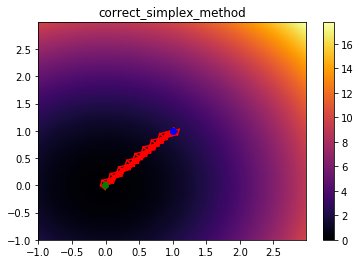

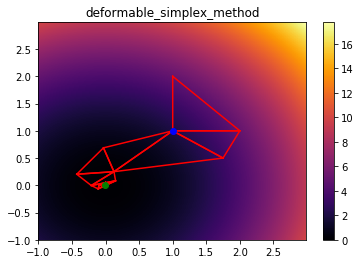

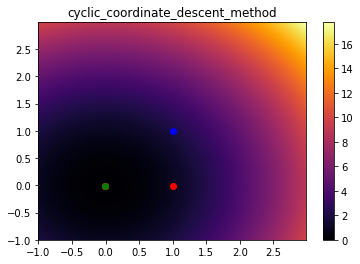

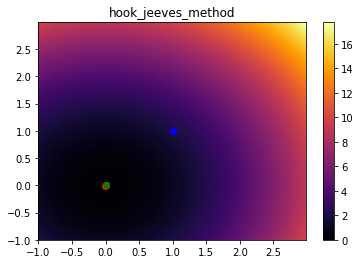

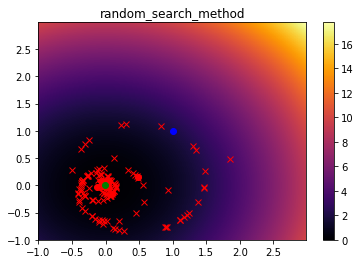

correct_simplex_method: ([[-0.0027598634518259946, -0.0027598634518550824], 1.5233692545610345e-05], 1047)
deformable_simplex_method: ([[-0.0012142149498686194, 0.008003259310498834], 6.552647753557072e-05], 71)
cyclic_coordinate_descent_method: [array([-0.00375, -0.00375]), 2.8125000000052105e-05, 4]
hook_jeeves_method: [array([-1.171875e-05, -1.171875e-05]), 2.746582032877877e-10, 527]
random_search_method: [array([-0.00177918, -0.00322975]), 1.3596802171554262e-05, 252]


In [10]:
func(sp.lambdify([x0, x1], x0**2 + 1 * x1**2), 0.01, [1,1], 2)

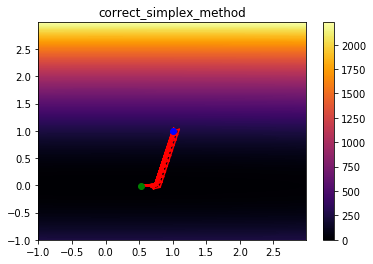

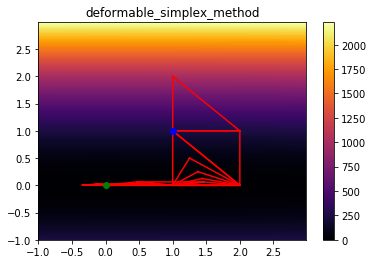

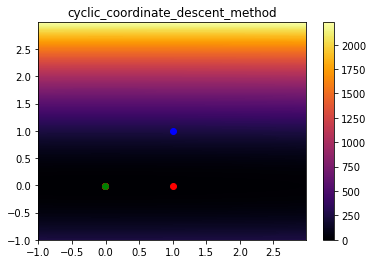

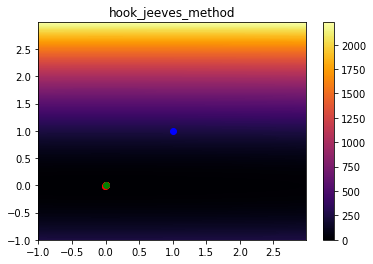

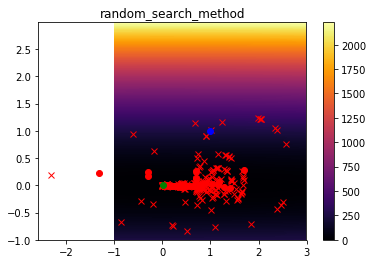

correct_simplex_method: ([[0.5347375374924102, -0.004431383162304403], 0.29085352318623553], 768)
deformable_simplex_method: ([[0.0, 0.0], 0.0], 83)
cyclic_coordinate_descent_method: [array([-0.00375, -0.00375]), 0.0035296875000065393, 4]
hook_jeeves_method: [array([-1.171875e-05, -1.171875e-05]), 3.4469604512617355e-08, 527]
random_search_method: [array([0.01517404, 0.00019512]), 0.00023976903579858277, 288]


In [11]:
func(sp.lambdify([x0, x1], x0**2 + 250 * x1**2), 0.01, [1,1], 2)

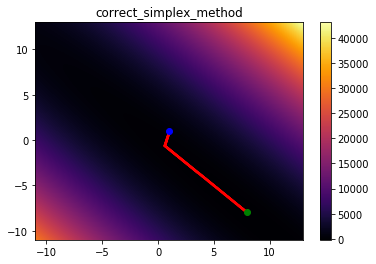

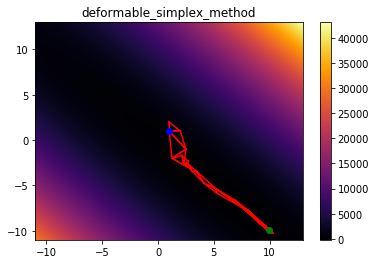

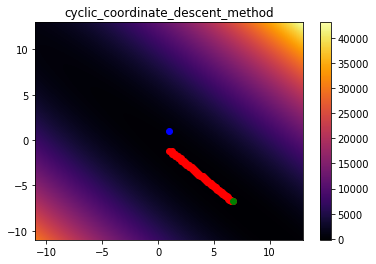

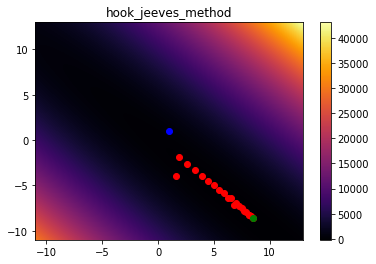

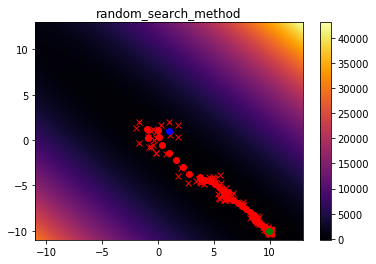

correct_simplex_method: ([[7.939800052176052, -7.899391846402612], -177.83607164738078], 307)
deformable_simplex_method: ([[9.924754051142372, -10.02118496177718], -187.37236635779482], 103)
cyclic_coordinate_descent_method: [array([ 6.6925, -6.755 ]), -165.90932500000054, 64]
hook_jeeves_method: [array([ 8.53035938, -8.5865    ]), -183.20501893750043, 366]
random_search_method: [array([  9.9689389 , -10.03455452]), -187.38275659156352, 192]


In [12]:
func(sp.lambdify([x0, x1], 64*x0**2+126*x0*x1+64*x1**2-10*x0+30*x1+13), 0.1, [1,1], 12)

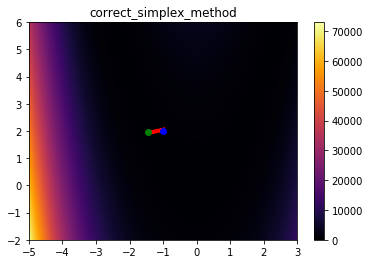

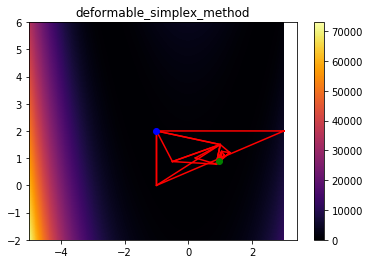

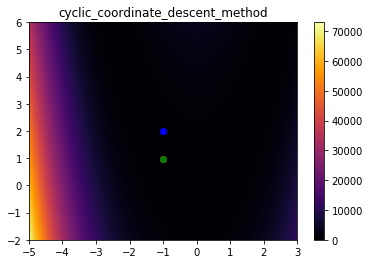

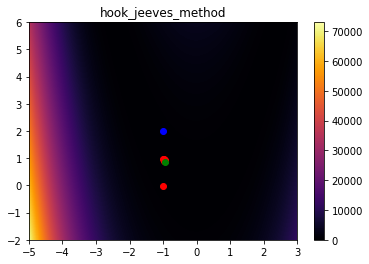

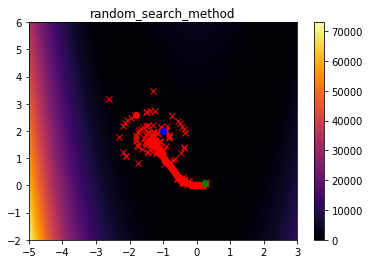

correct_simplex_method: ([[-1.4570810086342814, 1.9671830600776445], 8.467790619406177], 15)
deformable_simplex_method: ([[0.9191074371337891, 0.8476119041442871], 0.0073578090941569425], 55)
cyclic_coordinate_descent_method: [array([-1.    ,  0.9825]), 4.030624999999999, 2]
hook_jeeves_method: [array([-0.93086328,  0.87668945]), 3.738602369444157, 225]
random_search_method: [array([0.25328328, 0.08185008]), 0.5889065672565142, 190]


In [13]:
func(sp.lambdify([x0, x1], 100*(x0**2-x1)**2+(x0-1)**2), 0.1, [-1,2], 4)

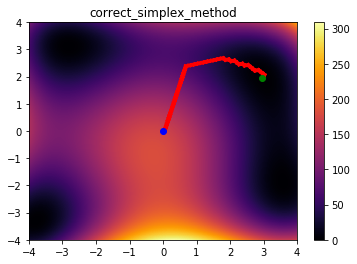

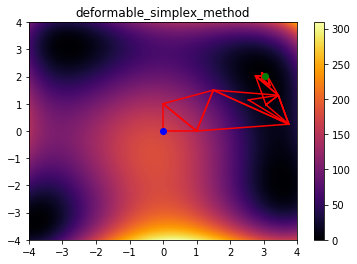

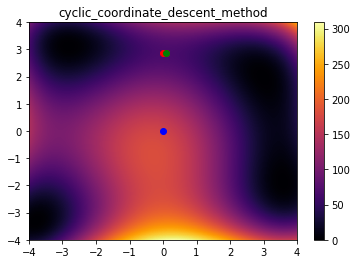

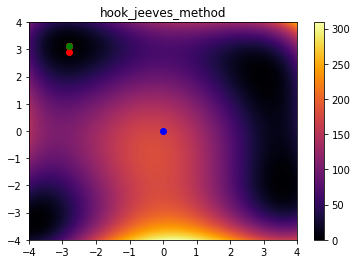

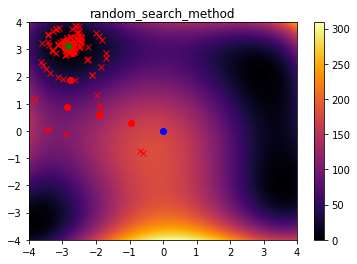

correct_simplex_method: ([[2.9444644896137615, 1.954514995952588], 0.19650206854760616], 111)
deformable_simplex_method: ([[2.9783873558044434, 1.9880337715148926], 0.024737631548758965], 55)
cyclic_coordinate_descent_method: [array([0.0825, 2.86  ]), 67.74173698503907, 2]
hook_jeeves_method: [array([-2.80534375,  3.13121875]), 2.035090149914503e-06, 416]
random_search_method: [array([-2.83582908,  3.12694972]), 0.03188489198121181, 161]


In [14]:
func(sp.lambdify([x0, x1], (x0**2+x1-11)**2 + (x0 + x1**2 - 7)**2), 0.1, [0,0], 4)

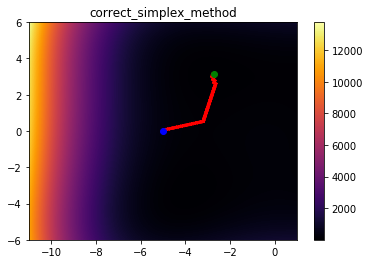

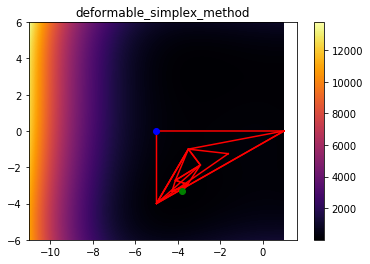

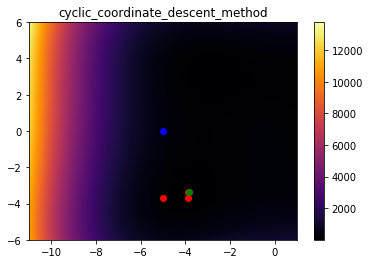

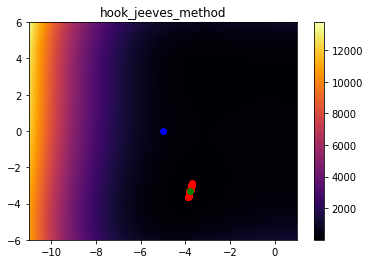

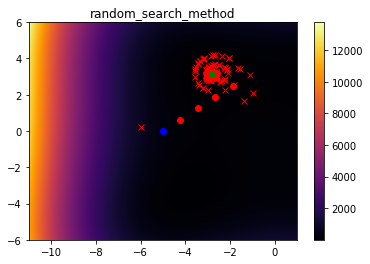

correct_simplex_method: ([[-2.729825351650468, 3.1187027857734164], 0.18435445663490466], 98)
deformable_simplex_method: ([[-3.7680158019065857, -3.2515944242477417], 0.04096179454569556], 55)
cyclic_coordinate_descent_method: [array([-3.8175, -3.355 ]), 0.23996179441402998, 4]
hook_jeeves_method: [array([-3.78321094, -3.29875391]), 0.009909409825533058, 353]
random_search_method: [array([-2.80245395,  3.15587828]), 0.024777396001182644, 160]


In [15]:
func(sp.lambdify([x0, x1], (x0**2+x1-11)**2 + (x0 + x1**2 - 7)**2), 0.1, [-5,0], 6)